In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
from math import ceil
from pathlib import Path
from matplotlib.colors import LogNorm
import yaml
import time
from make_waveform import BatchedLightSimulation, mod0_sampler
from tqdm import tqdm, trange

import sys
sys.path.append('/sdf/home/c/carsmith/flash_reconstruction/siren-lartpc')
sys.path.append('..')

In [2]:
device = torch.device('cuda:0')

sim = BatchedLightSimulation(cfg="templates/waveform_sim.yaml").to(device)

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]


In [5]:
params = dict()

params['singlet_fraction'] = 0.33
params['light_oscillation_period'] = 0.11
params['light_response_time'] = 0.055
params['tau_s'] = 0.001
params['tau_t'] = 1.530
params['tpb_tau'] = 0.002
params['light_gain'] = -45.0
params['light_tick_size'] = 0.001
params['downsample_factor'] = 16

# Check it is updated
sim.reconfigure(params)
print(sim.singlet_fraction)

0.33


In [13]:
times = []
nphotons_arr = np.logspace(4, 8, num=20) 
pmt_ids = torch.arange(128)

for i in range(len(nphotons_arr)):
    nphotons = torch.full_like(pmt_ids, nphotons_arr[i] // 128)
    wf = sim.gen_waveform(mode='gaussian', pmt_ids=pmt_ids, nphotons=nphotons, std=1.0) # 0.05 nanoseconds
    start_time = time.time()
    output, info = sim(wf.to(device), combined=True)
    end_time = time.time()
    times.append(end_time - start_time)

total combined sampling time: 0.0031 sec
sipm response conv. time: 0.0011 sec
total forward time: 0.0158 sec
total combined sampling time: 0.0032 sec
sipm response conv. time: 0.0005 sec
total forward time: 0.0044 sec
total combined sampling time: 0.0028 sec
sipm response conv. time: 0.0005 sec
total forward time: 0.0039 sec
total combined sampling time: 0.0033 sec
sipm response conv. time: 0.0004 sec
total forward time: 0.0043 sec
total combined sampling time: 0.0036 sec
sipm response conv. time: 0.0005 sec
total forward time: 0.0048 sec
total combined sampling time: 0.0061 sec
sipm response conv. time: 0.0006 sec
total forward time: 0.0076 sec
total combined sampling time: 0.0095 sec
sipm response conv. time: 0.0006 sec
total forward time: 0.0109 sec
total combined sampling time: 0.0175 sec
sipm response conv. time: 0.0007 sec
total forward time: 0.0213 sec
total combined sampling time: 0.0228 sec
sipm response conv. time: 0.0006 sec
total forward time: 0.0246 sec
total combined samp

Text(0.5, 1.0, 'Stochastic Waveforms Profiling')

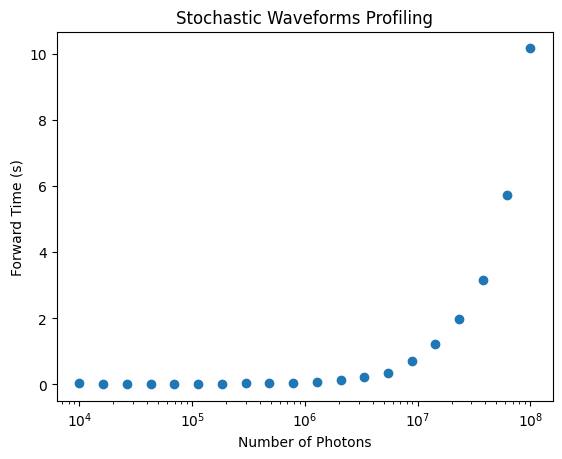

In [14]:
plt.scatter(nphotons_arr, times)
plt.xscale('log')
plt.xlabel("Number of Photons")
plt.ylabel("Forward Time (s)")
plt.title("Stochastic Waveforms Profiling")